# 🧠 Medical Imaging Final Project:
# Brain Tumor Classification: VGG16, EfficientNet, Resnet101, XCeption
### MIC — Spring 2025  
### **Team 1**

**Team Members:**  
- Lam Nguyen  
- Faramarz Aboutalebi  

---

This project focuses on applying deep learning techniques for tumor classification in MRI brain scans using convolutional neural networks and interpretability tools. The notebook includes data preprocessing, model training with transfer learning, performance evaluation, visualization techniques (Grad-CAM, ROC, PR curves), and several diagnostic tools.


# Step 1: Environment Setup and Library Imports

In [ ]:
%pip install -r requirements.txt

In [1]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageEnhance
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization,Input,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Check if GPU is available and show basic info
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("🔋 GPU detected — accelerated training enabled.")
    for device in gpu_devices:
        print("Device in use:", device)
else:
    print("⚙️ Training will proceed on CPU — no GPU found.")

# Print Dataset
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-04-21 19:07:57.597408: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 19:07:57.603654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745276877.611746   29815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745276877.614325   29815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 19:07:57.622367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

🔋 GPU detected — accelerated training enabled.
Device in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device in use: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
dataset/brain.tar.gz
dataset/Testing/glioma/Te-glTr_0000.jpg
dataset/Testing/glioma/Te-glTr_0001.jpg
dataset/Testing/glioma/Te-glTr_0002.jpg
dataset/Testing/glioma/Te-glTr_0003.jpg
dataset/Testing/glioma/Te-glTr_0004.jpg
dataset/Testing/glioma/Te-glTr_0005.jpg
dataset/Testing/glioma/Te-glTr_0006.jpg
dataset/Testing/glioma/Te-glTr_0007.jpg
dataset/Testing/glioma/Te-glTr_0008.jpg
dataset/Testing/glioma/Te-glTr_0009.jpg
dataset/Testing/glioma/Te-gl_0010.jpg
dataset/Testing/glioma/Te-gl_0011.jpg
dataset/Testing/glioma/Te-gl_0012.jpg
dataset/Testing/glioma/Te-gl_0013.jpg
dataset/Testing/glioma/Te-gl_0014.jpg
dataset/Testing/glioma/Te-gl_0015.jpg
dataset/Testing/glioma/Te-gl_0016.jpg
dataset/Testing/glioma/Te-gl_0018.jpg
dataset/Testing/glioma/Te-gl_0019.jpg
dataset/Testing/glioma/Te-gl_0

### Set Training Parameters for the Models

In [2]:
# Training Parameters
batch_size = 32
epochs = 15
image_size = 150
training_split = 0.1
verbose=1

# Step 2: Dataset Path Setup and Class Mapping

In [3]:
# Configure dataset paths relative to project location
project_root = os.getcwd()
train_path = os.path.join(project_root, "dataset", "Training")
test_path = os.path.join(project_root, "dataset", "Testing")


X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)



100%|██████████| 300/300 [00:00<00:00, 2135.36it/s]


# Step 3: Data Visualization

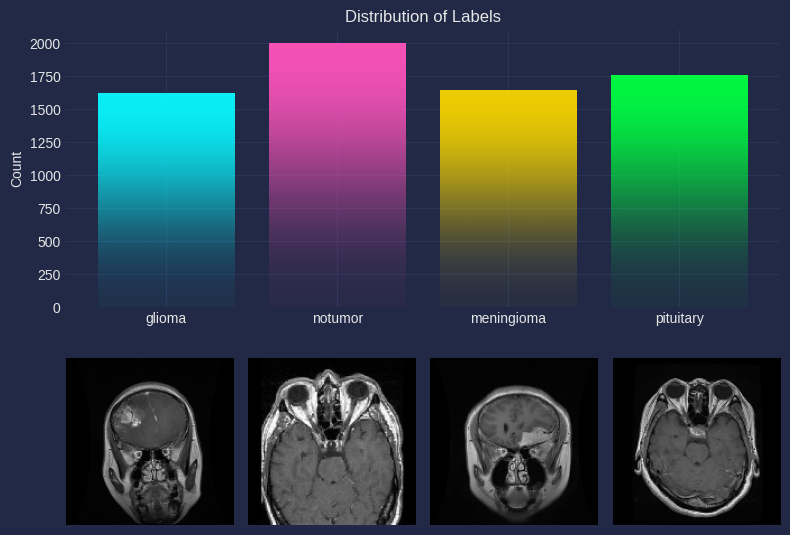

In [4]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Random Sample Image and Preview

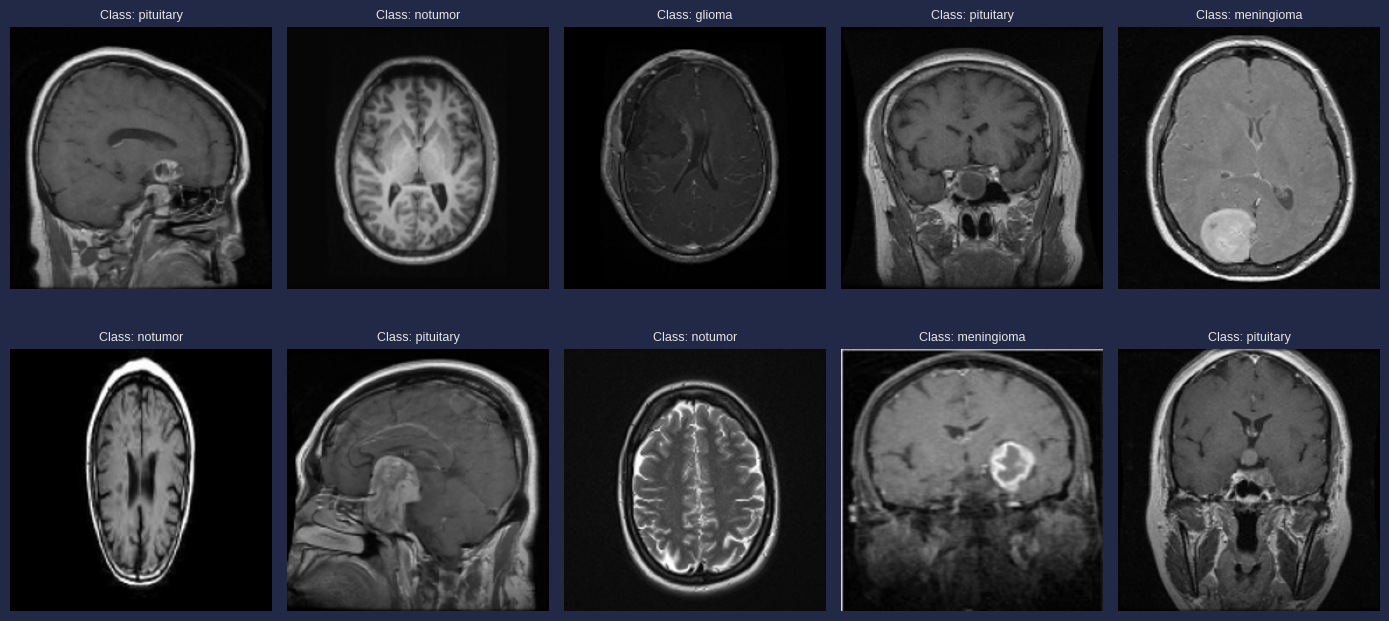

In [5]:
# Preview a few training images with labels
def preview_samples(images, labels, count=10):
    selected = random.sample(range(len(images)), count)
    fig, axarr = plt.subplots(2, 5, figsize=(14, 7))
    axarr = axarr.flatten()

    for i, idx in enumerate(selected):
        # Convert NumPy array to PIL Image (no .open() needed)
        img = Image.fromarray(images[idx]).resize((224, 224)) # Use fromarray() instead of open
        #img = Image.open(images[idx]).resize((224, 224))
        axarr[i].imshow(img)
        axarr[i].axis('off')
        axarr[i].set_title(f"Class: {labels[idx]}", fontsize=9)

    plt.tight_layout()
    plt.show()

# Display random examples from training set
preview_samples(X_train, y_train)

# Step 4: Preprocessing Functions (Augmentation, Normalization)

### Dataset Split and Train

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One Hot Encoding Labels

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Step 05: Compile and Train VGG16

In [8]:
# Load VGG16 pretrained on ImageNet (without top layers)
vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)  # Ensure `image_size` is defined (e.g., 224)
)

vgg16.trainable = False


# Build custom model on top of VGG16

model = vgg16.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(128, activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=vgg16.input, outputs=model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1745276924.262373   29815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1745276924.263820   29815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22321 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


In [9]:
# Get Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Get GPU Usage:
!nvidia-smi

Mon Apr 21 19:08:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   28C    P2            111W /  350W |   22602MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/vgg16_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=training_split, patience=2, 
                              min_delta=0.0001, verbose=1)

### Train VGG16 Model

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=training_split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tensorboard, checkpoint, reduce_lr],
    verbose=verbose
)


Epoch 1/15


I0000 00:00:1745276937.970649   29970 service.cc:148] XLA service 0x7dd57c004ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745276937.970680   29970 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1745276937.970685   29970 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-21 19:08:57.986929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745276938.098626   29970 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1745276938.570475   29970 buffer_comparator.cc:157] Difference at 64: 0.0213917, expected 2.43863
E0000 00:00:1745276938.570499   29970 buffer_comparator.cc:157] Difference at 65: -0.0158804, expected 2.59531
E0000 00:00:1745276938.570500   29970 buffer_comparator.cc:157] Difference at 66:

  7/178 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3151 - loss: 5.2395

I0000 00:00:1745276939.999631   29970 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/178 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6277 - loss: 2.2053

2025-04-21 19:09:04.500404: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_635', 8 bytes spill stores, 8 bytes spill loads

E0000 00:00:1745276944.622225   29984 buffer_comparator.cc:157] Difference at 39: 0, expected 0.132154
E0000 00:00:1745276944.622252   29984 buffer_comparator.cc:157] Difference at 41: 0, expected 0.115924
E0000 00:00:1745276944.622254   29984 buffer_comparator.cc:157] Difference at 52: 0, expected 0.11698
E0000 00:00:1745276944.622255   29984 buffer_comparator.cc:157] Difference at 69: 0, expected 0.117623
E0000 00:00:1745276944.622256   29984 buffer_comparator.cc:157] Difference at 70: 0, expected 0.128168
E0000 00:00:1745276944.622257   29984 buffer_comparator.cc:157] Difference at 82: 0, expected 0.123219
E0000 00:00:1745276944.622258   29984 buffer_comparator.cc:157] Difference at 83: 0, expected 0.113332
E0000 00:00:1745276944.622259   29984 buffer_com

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6292 - loss: 2.1885

E0000 00:00:1745276946.144239   29984 buffer_comparator.cc:157] Difference at 64: 8.07261, expected 65.568
E0000 00:00:1745276946.144265   29984 buffer_comparator.cc:157] Difference at 65: 7.95575, expected 66.5784
E0000 00:00:1745276946.144266   29984 buffer_comparator.cc:157] Difference at 66: 8.1084, expected 66.6715
E0000 00:00:1745276946.144268   29984 buffer_comparator.cc:157] Difference at 67: 7.66157, expected 70.089
E0000 00:00:1745276946.144269   29984 buffer_comparator.cc:157] Difference at 68: 7.80406, expected 67.9147
E0000 00:00:1745276946.144270   29984 buffer_comparator.cc:157] Difference at 69: 8.12491, expected 69.0356
E0000 00:00:1745276946.144271   29984 buffer_comparator.cc:157] Difference at 70: 8.25712, expected 70.3378
E0000 00:00:1745276946.144272   29984 buffer_comparator.cc:157] Difference at 71: 8.06372, expected 75.2111
E0000 00:00:1745276946.144273   29984 buffer_comparator.cc:157] Difference at 72: 8.12364, expected 64.8266
E0000 00:00:1745276946.144274  


Epoch 1: val_accuracy improved from -inf to 0.86076, saving model to checkpoints/vgg16_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6297 - loss: 2.1830 - val_accuracy: 0.8608 - val_loss: 0.3665 - learning_rate: 0.0010
Epoch 2/15
176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8358 - loss: 0.4537
Epoch 2: val_accuracy improved from 0.86076 to 0.88924, saving model to checkpoints/vgg16_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8359 - loss: 0.4531 - val_accuracy: 0.8892 - val_loss: 0.2715 - learning_rate: 0.0010
Epoch 3/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8761 - loss: 0.3406
Epoch 3: val_accuracy improved from 0.88924 to 0.90348, saving model to checkpoints/vgg16_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8761 - loss: 0.3404 - val_accuracy: 0.9035 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 4/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8942 - loss: 

In [13]:
model.save('checkpoints/vgg16_checkpoint.keras')

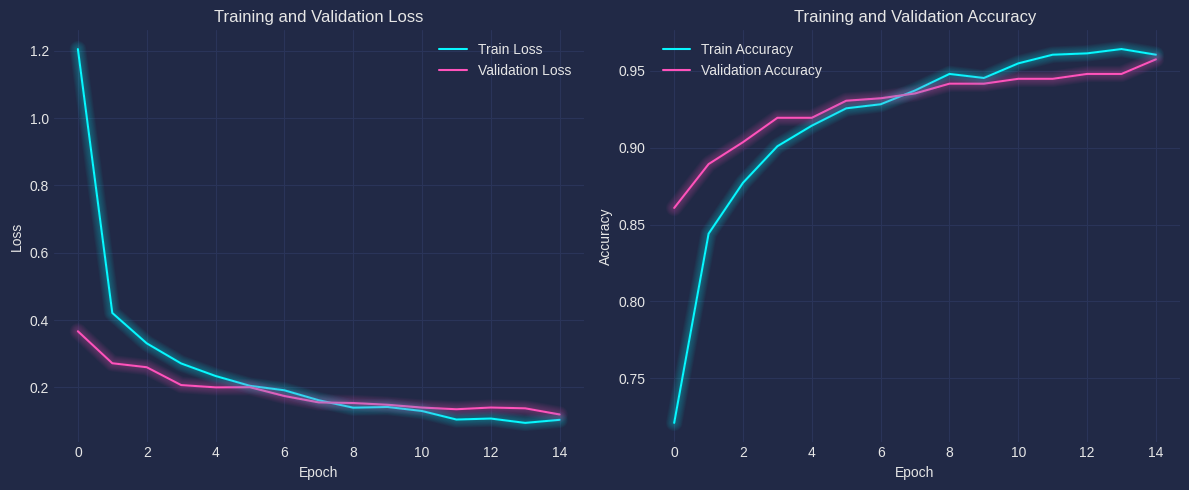

In [14]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

# VGG16 Evaluation and Visualization

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

E0000 00:00:1745277025.289823   29970 buffer_comparator.cc:157] Difference at 64: 1, expected 67.4759
E0000 00:00:1745277025.289848   29970 buffer_comparator.cc:157] Difference at 65: 0, expected 67.4586
E0000 00:00:1745277025.289850   29970 buffer_comparator.cc:157] Difference at 66: 0, expected 63.7247
E0000 00:00:1745277025.289851   29970 buffer_comparator.cc:157] Difference at 67: 0, expected 65.4951
E0000 00:00:1745277025.289852   29970 buffer_comparator.cc:157] Difference at 68: 0, expected 72.655
E0000 00:00:1745277025.289852   29970 buffer_comparator.cc:157] Difference at 69: 0, expected 71.6956
E0000 00:00:1745277025.289853   29970 buffer_comparator.cc:157] Difference at 70: 0, expected 70.0244
E0000 00:00:1745277025.289854   29970 buffer_comparator.cc:157] Difference at 71: 1, expected 71.6975
E0000 00:00:1745277025.289855   29970 buffer_comparator.cc:157] Difference at 72: 1, expected 69.4053
E0000 00:00:1745277025.289856   29970 buffer_comparator.cc:157] Difference at 73: 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Confusion Matrix:
[[152   1  17   0]
 [  0 201   1   1]
 [ 15   2 152   5]
 [  1   1   3 151]]


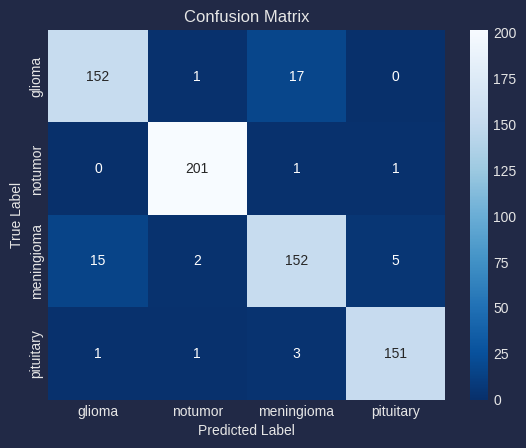

In [15]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
### Classification Report
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       170
           1       0.98      0.99      0.99       203
           2       0.88      0.87      0.88       174
           3       0.96      0.97      0.96       156

    accuracy                           0.93       703
   macro avg       0.93      0.93      0.93       703
weighted avg       0.93      0.93      0.93       703



### ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


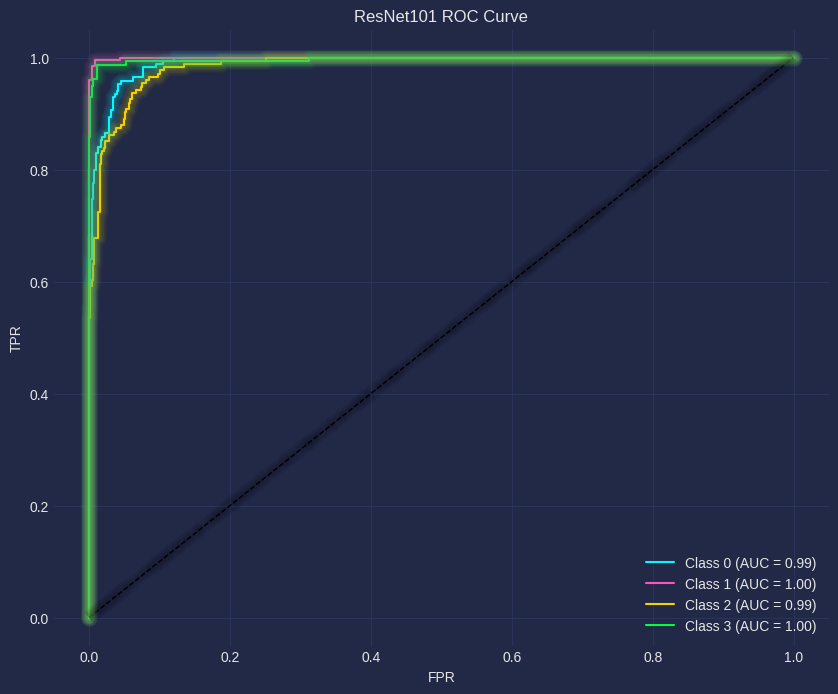

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ResNet101 ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Precision Recall Curves

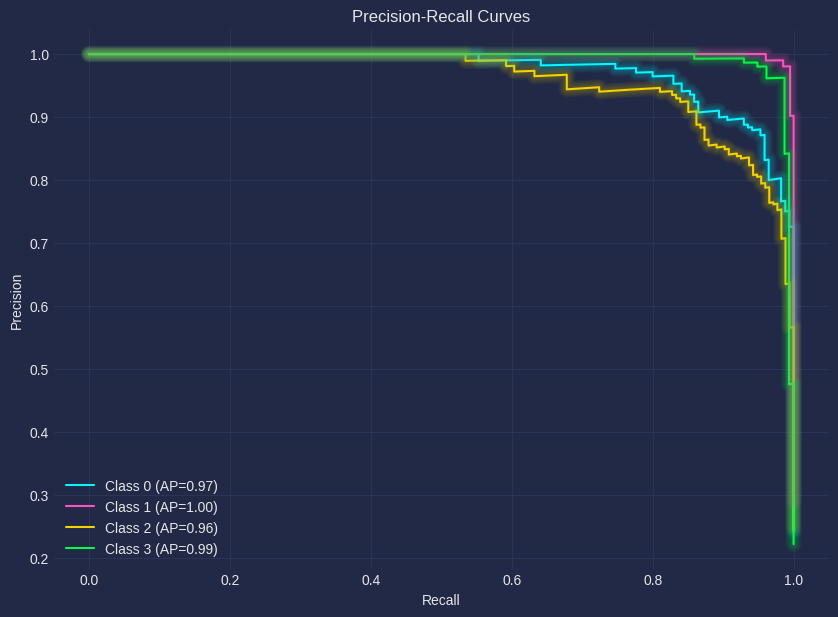

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()


# VGG16 Prediction and Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


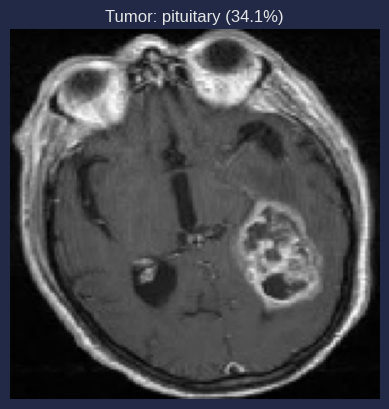

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


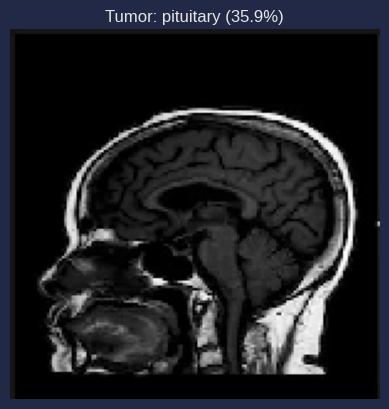

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


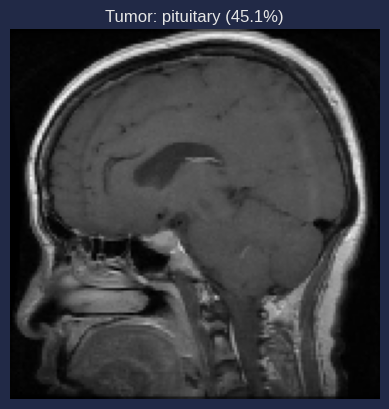

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


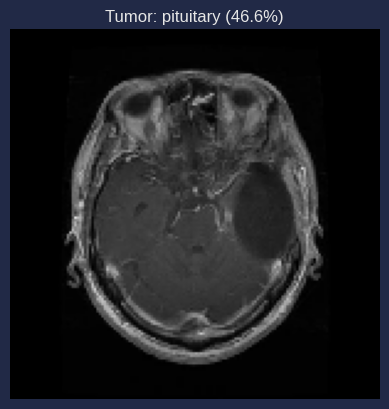

In [19]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/vgg16_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Upload and Detect Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


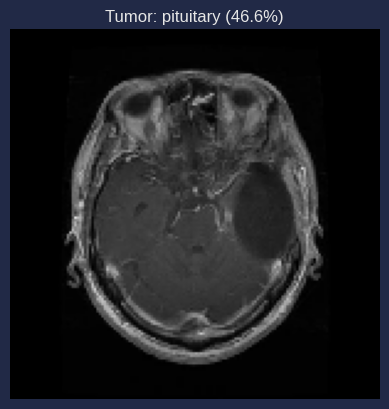

In [20]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()


In [21]:
# Clear GPU Memory
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

# Step 06: Compile and Train EfficientNet

In [22]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
#Get Model Size
!nvidia-smi

Mon Apr 21 19:11:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   34C    P2            114W /  350W |   22618MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
# Get Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [25]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/efficientnet_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

### Train Efficientnet Model

In [26]:
history = model.fit(X_train,y_train,validation_split = training_split, epochs = epochs, verbose = verbose,
                    batch_size = batch_size, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


2025-04-21 19:12:02.600781: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511_0', 8 bytes spill stores, 8 bytes spill loads

2025-04-21 19:12:02.832548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388', 4 bytes spill stores, 4 bytes spill loads

2025-04-21 19:12:02.910642: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 232 bytes spill stores, 232 bytes spill loads

2025-04-21 19:12:03.027473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388_0', 24 bytes spill stores, 24 bytes spill loads

2025-04-21 19:12:03.081742: I external/local_xla/xla/s

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8294 - loss: 0.4727

2025-04-21 19:12:24.659127: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 108 bytes spill stores, 108 bytes spill loads

2025-04-21 19:12:24.790349: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388_0', 24 bytes spill stores, 24 bytes spill loads

2025-04-21 19:12:24.856808: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 8 bytes spill stores, 8 bytes spill loads

E0000 00:00:1745277145.011890   29984 buffer_comparator.cc:157] Difference at 16: 0, expected 0.219782
E0000 00:00:1745277145.011914   29984 buffer_comparator.cc:157] Difference at 17: 0, expected 0.210586
E0000 00:00:1745277145.011916   29984 buffer_comparator.cc:157] Difference at 18: 0,

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8297 - loss: 0.4718

2025-04-21 19:12:39.556936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2084', 196 bytes spill stores, 196 bytes spill loads

E0000 00:00:1745277159.558419   29973 buffer_comparator.cc:157] Difference at 39: 472.156, expected 528.569
E0000 00:00:1745277159.558450   29973 buffer_comparator.cc:157] Difference at 55: 458.375, expected 533.637
E0000 00:00:1745277159.558452   29973 buffer_comparator.cc:157] Difference at 64: 23.5269, expected 512.719
E0000 00:00:1745277159.558453   29973 buffer_comparator.cc:157] Difference at 65: 26.7269, expected 529.412
E0000 00:00:1745277159.558454   29973 buffer_comparator.cc:157] Difference at 66: 21.7279, expected 521.502
E0000 00:00:1745277159.558455   29973 buffer_comparator.cc:157] Difference at 67: 20.9737, expected 526.731
E0000 00:00:1745277159.558456   29973 buffer_comparator.cc:157] Difference at 68: 22.7224, expected 512.801
E0000 0


Epoch 1: val_accuracy improved from -inf to 0.91772, saving model to checkpoints/efficientnet_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.8300 - loss: 0.4710 - val_accuracy: 0.9177 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9659 - loss: 0.1031
Epoch 2: val_accuracy improved from 0.91772 to 0.93038, saving model to checkpoints/efficientnet_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9659 - loss: 0.1032 - val_accuracy: 0.9304 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9674 - loss: 0.0979
Epoch 3: val_accuracy improved from 0.93038 to 0.93513, saving model to checkpoints/efficientnet_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9674 - loss: 0.0979 - val_accuracy: 0.9351 - val_loss: 0.2759 - learning_rate: 0.0010
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc

In [27]:
model.save('checkpoints/efficientnet_checkpoint.keras')

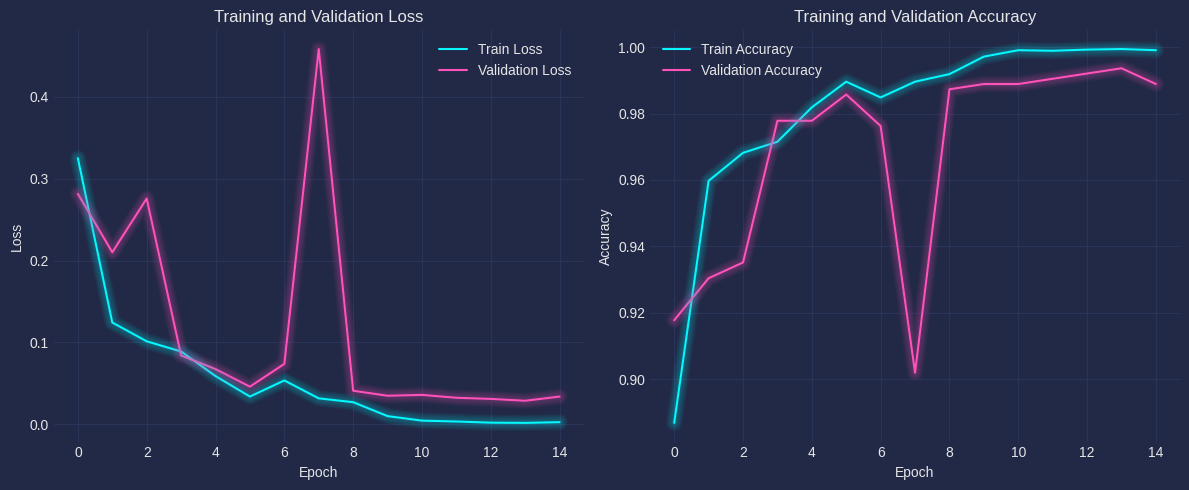

In [28]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()


### Evaluation

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[168   0   2   0]
 [  0 203   0   0]
 [  3   0 170   1]
 [  0   1   1 154]]


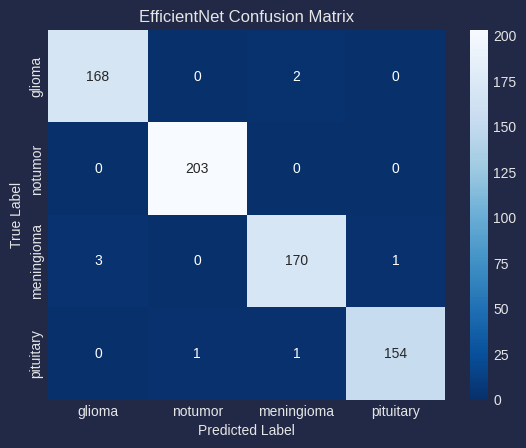

In [30]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('EfficientNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Print Classification Report
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       170
           1       1.00      1.00      1.00       203
           2       0.99      0.97      0.98       174
           3       0.99      0.99      0.99       156

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



### ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


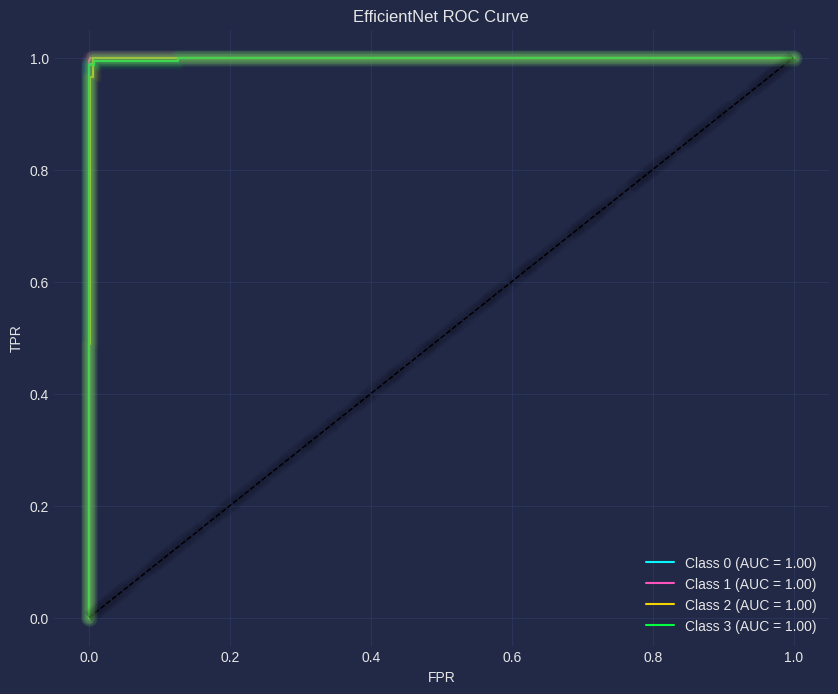

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("EfficientNet ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Precision Recall Curves

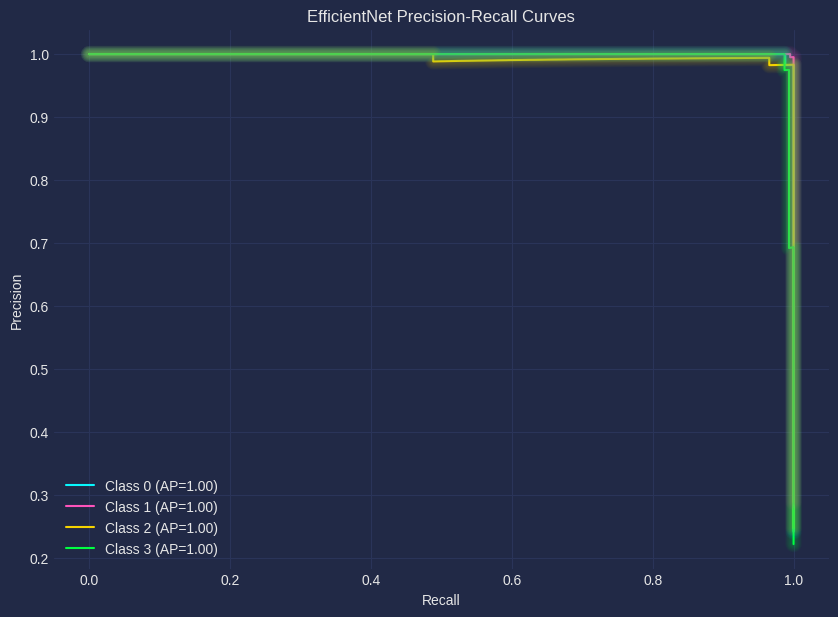

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("EfficientNet Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

# Efficientnet Prediction and Inference

E0000 00:00:1745277349.933951   29985 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745277350.040285   29985 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745277350.199760   29985 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745277350.306143   29985 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


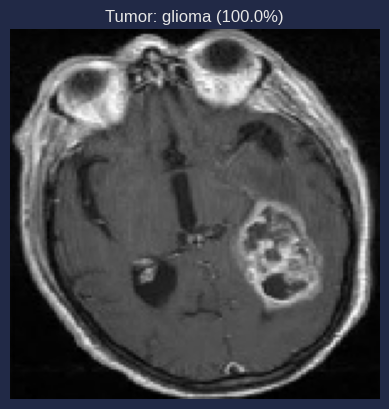

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


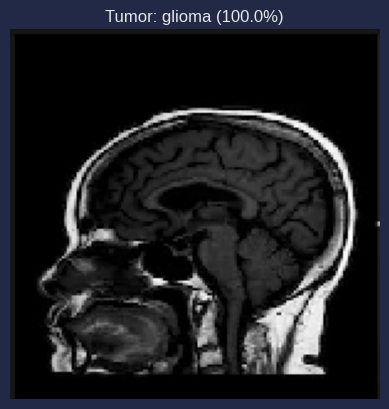

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


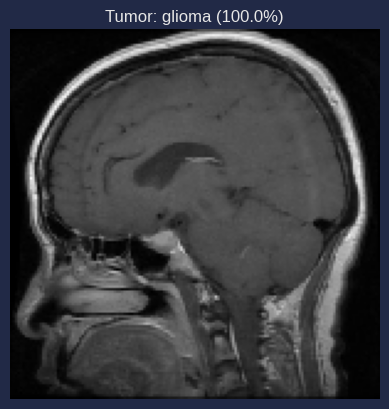

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


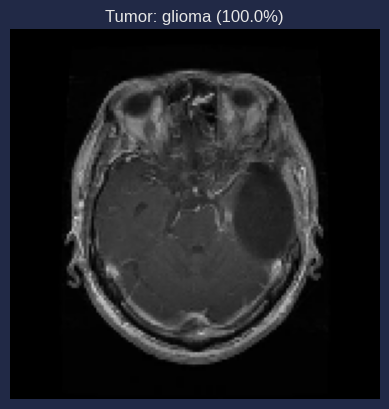

In [33]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/efficientnet_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Upload and Detect Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


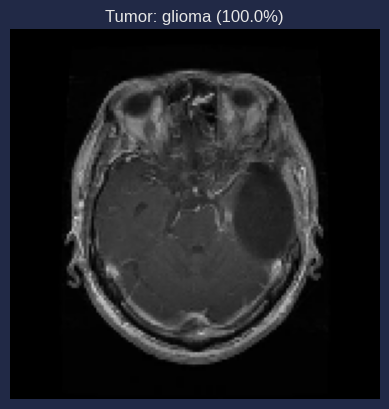

In [34]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()

In [35]:
# Clear GPU Memory
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()


# Step 07: Compile and Train ResNet101

In [36]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
!nvidia-smi

Mon Apr 21 19:16:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   37C    P5            116W /  350W |   22646MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [38]:
# Get Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 42,666,372 (162.76 MB)

 Trainable params: 42,561,028 (162.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [39]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/resnet101_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

### Train Resnet101 Model

In [40]:
history = model.fit(X_train,y_train,validation_split=training_split, epochs =epochs, verbose=1, batch_size=batch_size,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


E0000 00:00:1745277423.817123   29971 buffer_comparator.cc:157] Difference at 64: 9.27076e-07, expected 2.20132
E0000 00:00:1745277423.817155   29971 buffer_comparator.cc:157] Difference at 65: 8.95288e-07, expected 2.06797
E0000 00:00:1745277423.817161   29971 buffer_comparator.cc:157] Difference at 66: 1.71704e-06, expected 1.64481
E0000 00:00:1745277423.817163   29971 buffer_comparator.cc:157] Difference at 67: 7.77995e-07, expected 2.01379
E0000 00:00:1745277423.817165   29971 buffer_comparator.cc:157] Difference at 68: 1.17704e-06, expected 1.78577
E0000 00:00:1745277423.817167   29971 buffer_comparator.cc:157] Difference at 69: 4.52228e-07, expected 1.67553
E0000 00:00:1745277423.817168   29971 buffer_comparator.cc:157] Difference at 70: 4.7176e-07, expected 1.77877
E0000 00:00:1745277423.817170   29971 buffer_comparator.cc:157] Difference at 71: 1.20794e-06, expected 2.00766
E0000 00:00:1745277423.817171   29971 buffer_comparator.cc:157] Difference at 72: 2.6938e-06, expected 2.

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7065 - loss: 0.8908

E0000 00:00:1745277453.285367   29971 buffer_comparator.cc:157] Difference at 23: 0, expected 0.139466
E0000 00:00:1745277453.285387   29971 buffer_comparator.cc:157] Difference at 39: 0, expected 0.132154
E0000 00:00:1745277453.285389   29971 buffer_comparator.cc:157] Difference at 41: 0, expected 0.115924
E0000 00:00:1745277453.285391   29971 buffer_comparator.cc:157] Difference at 52: 0, expected 0.11698
E0000 00:00:1745277453.285392   29971 buffer_comparator.cc:157] Difference at 69: 0, expected 0.117623
E0000 00:00:1745277453.285393   29971 buffer_comparator.cc:157] Difference at 70: 0, expected 0.128168
E0000 00:00:1745277453.285394   29971 buffer_comparator.cc:157] Difference at 82: 0, expected 0.123219
E0000 00:00:1745277453.285395   29971 buffer_comparator.cc:157] Difference at 83: 0, expected 0.113332
E0000 00:00:1745277453.285396   29971 buffer_comparator.cc:157] Difference at 88: 0, expected 0.118887
E0000 00:00:1745277453.285397   29971 buffer_comparator.cc:157] Difference

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7069 - loss: 0.8892

2025-04-21 19:17:43.918571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3321', 192 bytes spill stores, 192 bytes spill loads

E0000 00:00:1745277463.920084   29971 buffer_comparator.cc:157] Difference at 36: 18.0921, expected 20.4329
E0000 00:00:1745277463.920114   29971 buffer_comparator.cc:157] Difference at 64: 28.5426, expected 21.0351
E0000 00:00:1745277463.920116   29971 buffer_comparator.cc:157] Difference at 68: 33.3029, expected 21.1176
E0000 00:00:1745277463.920117   29971 buffer_comparator.cc:157] Difference at 72: 31.9124, expected 20.5265
E0000 00:00:1745277463.920118   29971 buffer_comparator.cc:157] Difference at 74: 24.2683, expected 20.3628
E0000 00:00:1745277463.920119   29971 buffer_comparator.cc:157] Difference at 75: 23.4762, expected 19.9434
E0000 00:00:1745277463.920120   29971 buffer_comparator.cc:157] Difference at 76: 39.9836, expected 20.8433
E0000 0


Epoch 1: val_accuracy improved from -inf to 0.26741, saving model to checkpoints/resnet101_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.7074 - loss: 0.8877 - val_accuracy: 0.2674 - val_loss: 540.0608 - learning_rate: 0.0010
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8942 - loss: 0.3250
Epoch 2: val_accuracy improved from 0.26741 to 0.55380, saving model to checkpoints/resnet101_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8941 - loss: 0.3251 - val_accuracy: 0.5538 - val_loss: 1.8575 - learning_rate: 0.0010
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9384 - loss: 0.1887
Epoch 3: val_accuracy improved from 0.55380 to 0.85443, saving model to checkpoints/resnet101_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.9384 - loss: 0.1888 - val_accuracy: 0.8544 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accura

In [41]:
# Save Model
model.save('checkpoints/resnet101_checkpoint.keras')

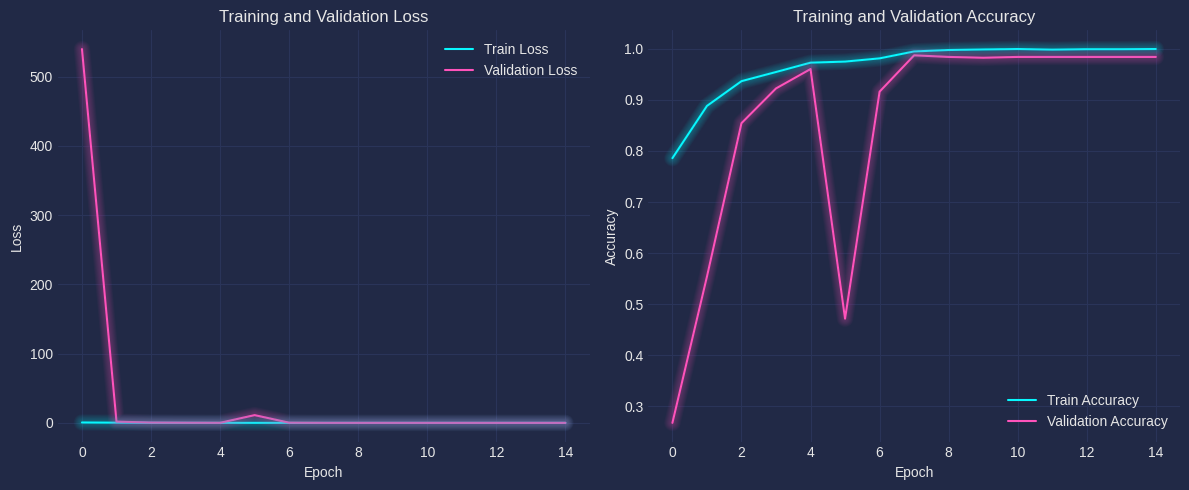

In [42]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

# ResNet101 Evaluation and Visualization

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

2025-04-21 19:22:50.913654: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3276', 176 bytes spill stores, 176 bytes spill loads

E0000 00:00:1745277770.914902   29971 buffer_comparator.cc:157] Difference at 52: 18.537, expected 20.8719
E0000 00:00:1745277770.914922   29971 buffer_comparator.cc:157] Difference at 64: 5, expected 21.1596
E0000 00:00:1745277770.914924   29971 buffer_comparator.cc:157] Difference at 65: 0, expected 20.9341
E0000 00:00:1745277770.914925   29971 buffer_comparator.cc:157] Difference at 66: 2, expected 21.019
E0000 00:00:1745277770.914926   29971 buffer_comparator.cc:157] Difference at 67: 1, expected 20.3573
E0000 00:00:1745277770.914927   29971 buffer_comparator.cc:157] Difference at 68: 1, expected 21.4978
E0000 00:00:1745277770.914929   29971 buffer_comparator.cc:157] Difference at 69: 3, expected 20.7887
E0000 00:00:1745277770.914930   29971 buffer_

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step
Confusion Matrix:
[[165   0   5   0]
 [  0 202   1   0]
 [  2   1 169   2]
 [  0   1   4 151]]


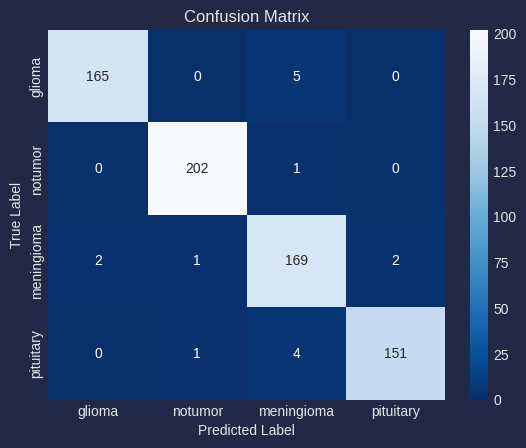

In [43]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 
conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)


heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Classification Report
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       170
           1       0.99      1.00      0.99       203
           2       0.94      0.97      0.96       174
           3       0.99      0.97      0.98       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



### ResNet101 ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


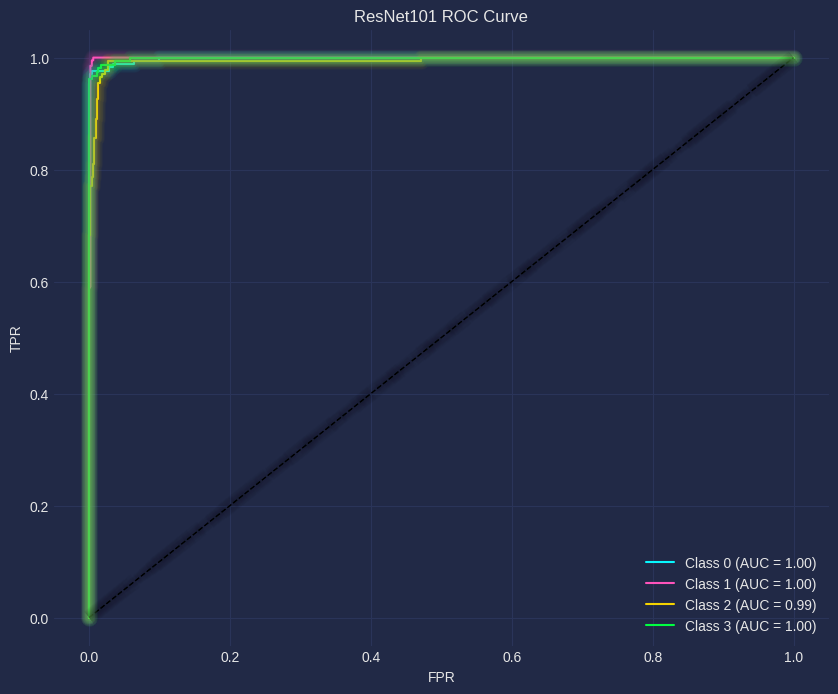

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ResNet101 ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Resnet Precision Recall Curves

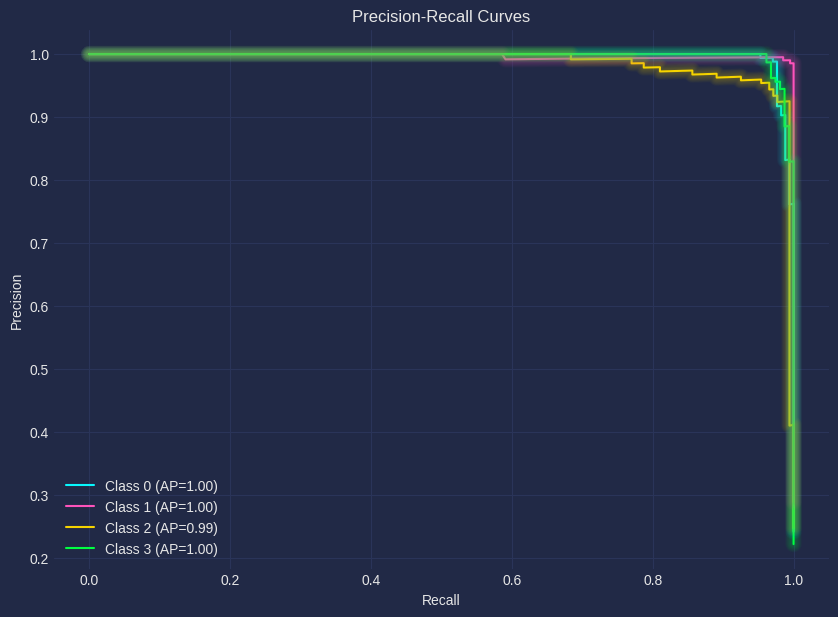

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

# ResNet101 Prediction and Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


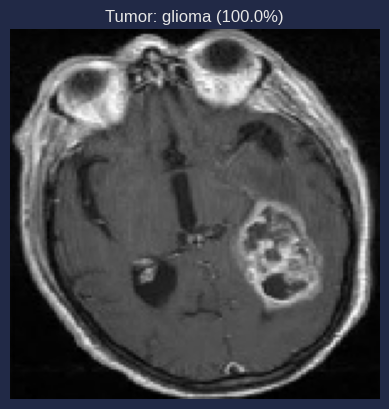

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


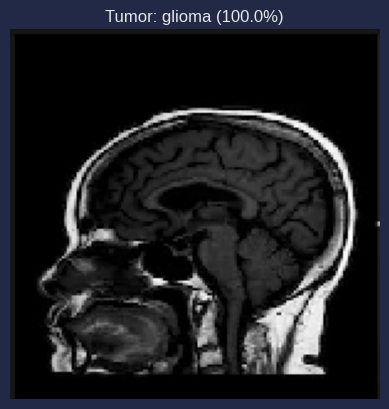

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


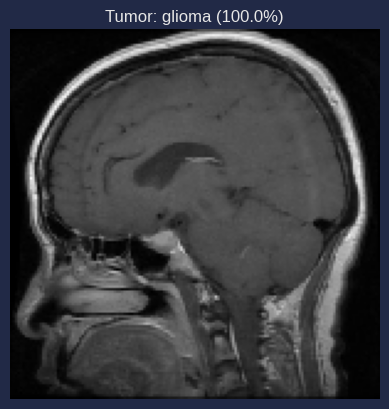

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


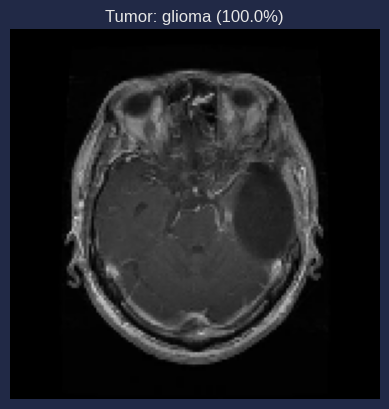

In [47]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/efficientnet_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Upload and Detect Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


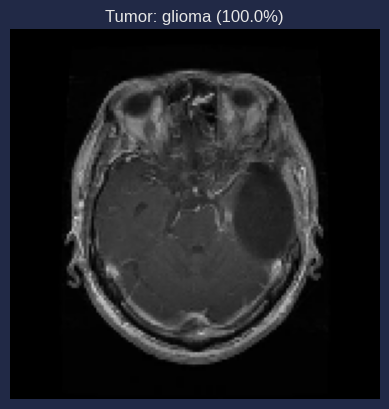

In [48]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()

In [49]:
# Clear GPU Memory
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

# Step 08: Compile and Train XCeption

In [50]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
!nvidia-smi

Mon Apr 21 19:23:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   38C    P2            115W /  350W |   22680MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [52]:
# Get Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 24,014,892 (91.61 MB)

 Trainable params: 23,960,364 (91.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [53]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/xception_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

### Train Xception Model

In [54]:
# Train Model
history = model.fit(X_train,y_train,validation_split=training_split, epochs =epochs, verbose=verbose, batch_size=batch_size,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


2025-04-21 19:24:16.343934: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12845', 56 bytes spill stores, 56 bytes spill loads

2025-04-21 19:24:16.348048: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292', 144 bytes spill stores, 388 bytes spill loads

2025-04-21 19:24:16.356041: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292_0', 76 bytes spill stores, 116 bytes spill loads

2025-04-21 19:24:16.361520: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12845_0', 32 bytes spill stores, 32 bytes spill loads

E0000 00:00:1745277856.568880   29971 buffer_comp

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8083 - loss: 0.5517

2025-04-21 19:24:35.862516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292_0', 52 bytes spill stores, 52 bytes spill loads

2025-04-21 19:24:35.898832: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12845_0', 28 bytes spill stores, 28 bytes spill loads

2025-04-21 19:24:36.070964: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292', 20 bytes spill stores, 44 bytes spill loads

2025-04-21 19:24:36.165493: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292', 16 bytes spill stores, 16 bytes spill loads

E0000 00:00:1745277876.250184   29972 buffer_compara

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8086 - loss: 0.5507

2025-04-21 19:24:44.437983: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1066', 200 bytes spill stores, 200 bytes spill loads

E0000 00:00:1745277884.439525   29971 buffer_comparator.cc:157] Difference at 64: 124.8, expected 770.446
E0000 00:00:1745277884.439545   29971 buffer_comparator.cc:157] Difference at 65: 125.03, expected 775.623
E0000 00:00:1745277884.439546   29971 buffer_comparator.cc:157] Difference at 66: 124.932, expected 779.887
E0000 00:00:1745277884.439547   29971 buffer_comparator.cc:157] Difference at 67: 125.885, expected 776.089
E0000 00:00:1745277884.439548   29971 buffer_comparator.cc:157] Difference at 68: 125.43, expected 777.27
E0000 00:00:1745277884.439549   29971 buffer_comparator.cc:157] Difference at 69: 125.008, expected 779.97
E0000 00:00:1745277884.439550   29971 buffer_comparator.cc:157] Difference at 70: 125.884, expected 778.46
E0000 00:00:17


Epoch 1: val_accuracy improved from -inf to 0.73892, saving model to checkpoints/xception_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.8090 - loss: 0.5498 - val_accuracy: 0.7389 - val_loss: 1.6872 - learning_rate: 0.0010
Epoch 2/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9453 - loss: 0.1658
Epoch 2: val_accuracy improved from 0.73892 to 0.90032, saving model to checkpoints/xception_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9453 - loss: 0.1657 - val_accuracy: 0.9003 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9654 - loss: 0.1138
Epoch 3: val_accuracy improved from 0.90032 to 0.93196, saving model to checkpoints/xception_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9653 - loss: 0.1138 - val_accuracy: 0.9320 - val_loss: 0.2140 - learning_rate: 0.0010
Epoch 4/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9

In [55]:
#Save Model
model.save('checkpoints/xception_checkpoint.keras')

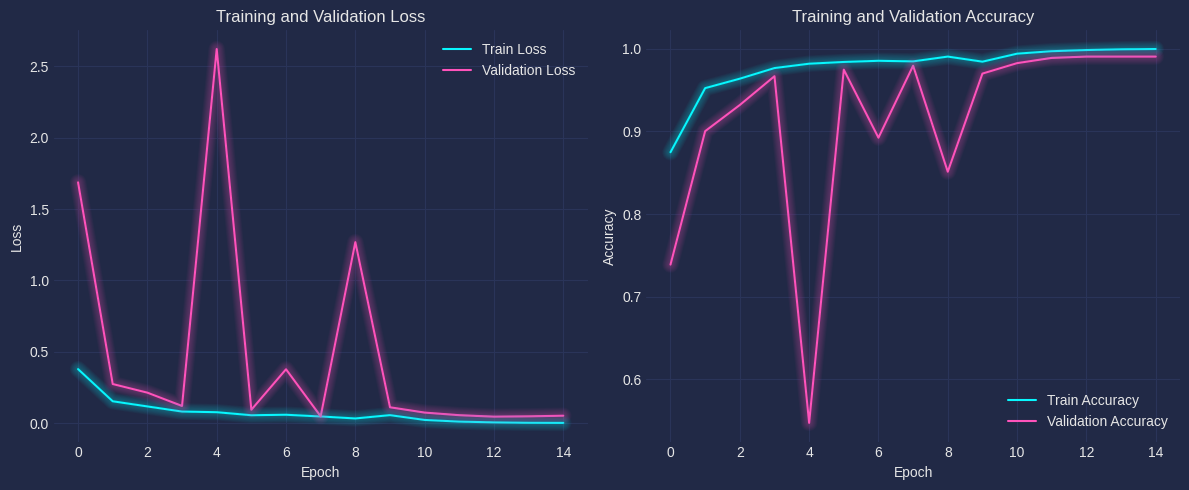

In [56]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

# Xception Evaluation and Visualization

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix:
[[167   0   2   1]
 [  0 201   0   2]
 [  2   2 168   2]
 [  1   0   1 154]]


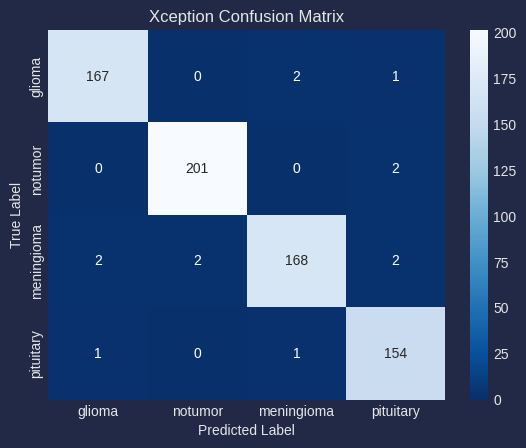

In [58]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Xception Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [59]:
# Classification Report
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       170
           1       0.99      0.99      0.99       203
           2       0.98      0.97      0.97       174
           3       0.97      0.99      0.98       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



### XCeption ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


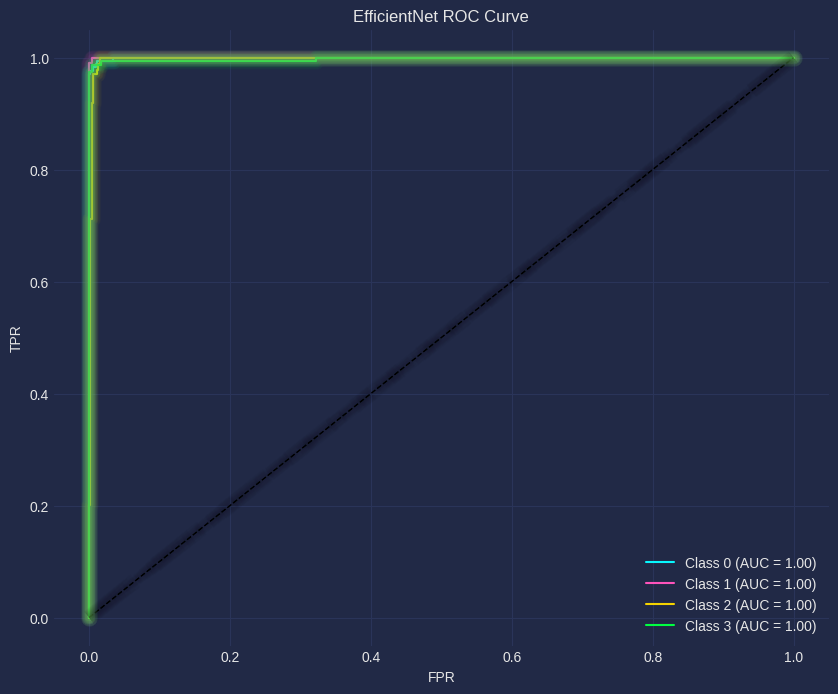

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("EfficientNet ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Xception Precision Recall Curves

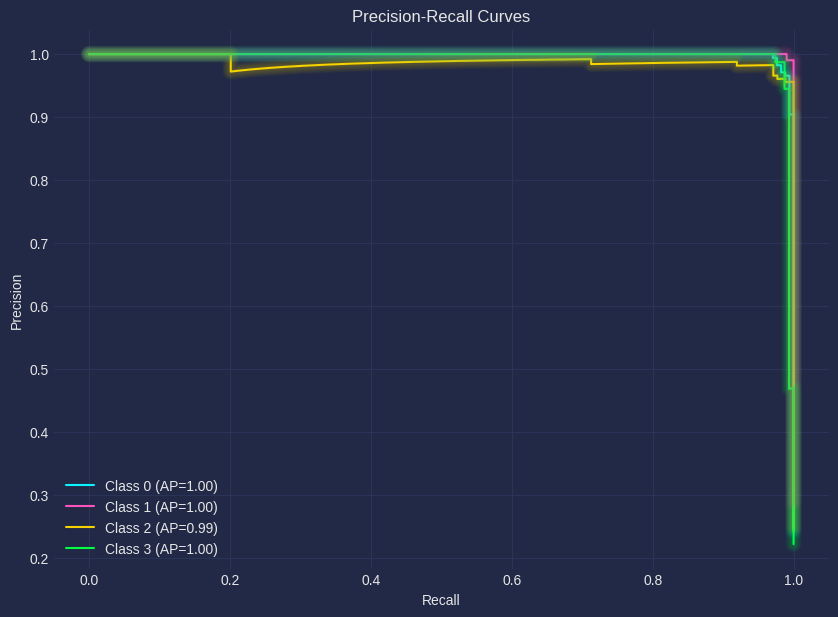

In [61]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

# XCeption Prediction and Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


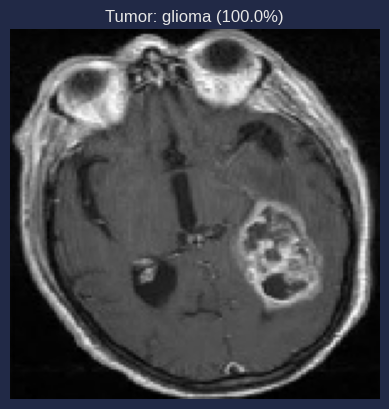

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


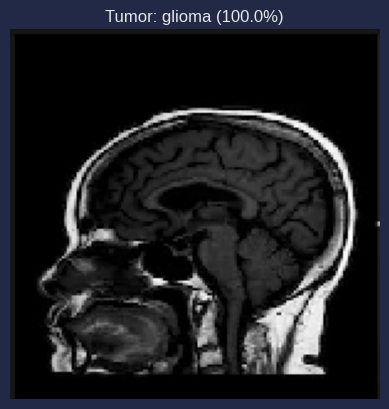

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


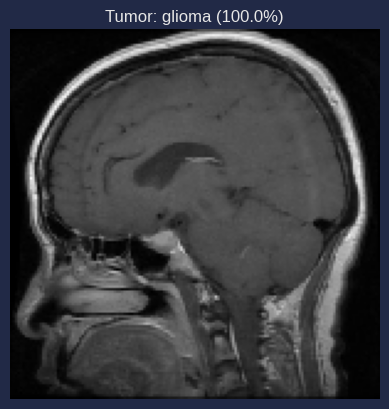

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


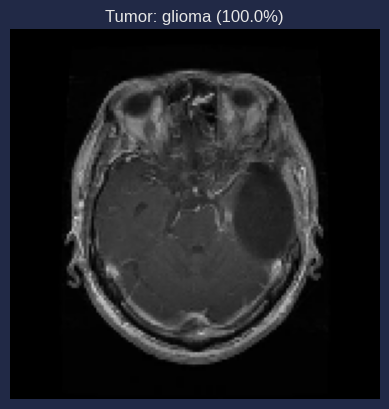

In [62]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/efficientnet_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Upload and Detect Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


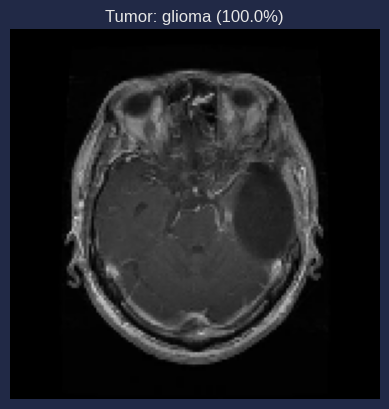

In [63]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()

In [64]:
# Clear GPU Memory
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()